In [63]:
import pandas as pd
import pyarrow.parquet as pq
import seaborn as sns
import plotly.express as px
from matplotlib import pyplot as plt
import warnings
import numpy as np
import datetime
warnings.filterwarnings('ignore')

In [3]:
parquetDf = pq.ParquetDataset('/Users/gorkagamo/PycharmProjects/exploracio-ml-python/data')
eventsDf = parquetDf.read().to_pandas()

Explore sample data
We will sample randomly 1M rows and look at different areas.

In [84]:
sampleEventsDf = eventsDf.head(n=1000000)

In [85]:
nEvents = len(sampleEventsDf)
actionFreq = ((sampleEventsDf.groupby(['type']).size() / nEvents) * 100).round(2)
print(actionFreq)

type
carts      7.10
clicks    91.04
orders     1.86
dtype: float64


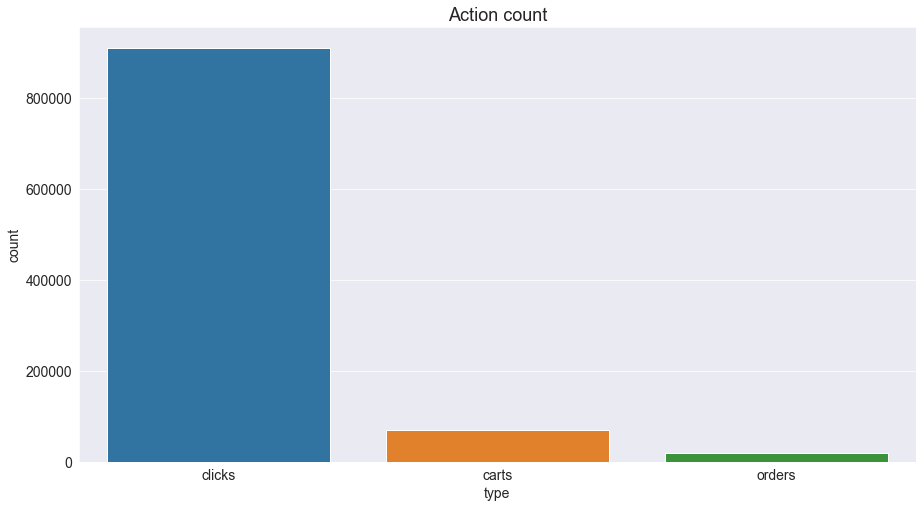

In [86]:
plt.figure(figsize=(15,8))
plt.title('Action count',fontsize=18)
b = sns.countplot(x=sampleEventsDf['type'])
b.set_xlabel('type',fontsize=14)
b.set_ylabel('count',fontsize=14)
b.tick_params(labelsize=14)


Distribution of number of actions performed in events --> list comprehension

In [87]:
listofactions = [i for i in sampleEventsDf.groupby(['sessionId']).size()]

pd.Series(listofactions).describe().round()

count    17371.0
mean        58.0
std         82.0
min          2.0
25%          7.0
50%         22.0
75%         72.0
max        495.0
dtype: float64

In [88]:
nbins=25
px.histogram(listofactions,nbins=nbins,title=f"Number of events per sessionId - bins = {nbins}")

Insights:
* Range of events per session = [2 , 495]
* mean is at 58 actions
* standar deviation is at 82 actions.

-----
* carts      7.10 %
* clicks    91.04 %
* orders     1.86 %




Creating Subsessions --> based on sessionId & cut difference (24h)


In [89]:
sampleEventsDf = sampleEventsDf.sort_values(by=['sessionId','ts'])
sampleEventsDf

,sessionId,aid,type
ts,,,
2022-07-31 22:00:00.025,0,1517085,clicks
2022-07-31 22:01:44.511,0,1563459,clicks
2022-08-01 15:23:59.426,0,1309446,clicks
2022-08-01 15:28:39.997,0,16246,clicks
2022-08-01 15:31:11.344,0,1781822,clicks
...,...,...,...
2022-08-02 01:28:45.227,17370,1577151,clicks
2022-08-02 01:28:49.415,17370,707369,clicks
2022-08-02 01:29:08.426,17370,723746,clicks


In [91]:
sampleEventsDf.reset_index(inplace=True)
llisteta = [(sampleEventsDf[sampleEventsDf['sessionId']==session]['ts'] - np.insert(sampleEventsDf[sampleEventsDf['sessionId']==session]['ts'].values,0,0,axis=0)[:-1]).values for session in pd.unique(sampleEventsDf['sessionId'])]
llisteta = [item for sublist in llisteta for item in sublist]
print(llisteta[:10])

[numpy.timedelta64(1659304800025000000,'ns'), numpy.timedelta64(104486000000,'ns'), numpy.timedelta64(62534915000000,'ns'), numpy.timedelta64(280571000000,'ns'), numpy.timedelta64(151347000000,'ns'), numpy.timedelta64(14452000000,'ns'), numpy.timedelta64(2008044000000,'ns'), numpy.timedelta64(4210000000,'ns'), numpy.timedelta64(129055000000,'ns'), numpy.timedelta64(0,'ns')]


In [92]:
sampleEventsDf['dif'] = llisteta
sampleEventsDf[sampleEventsDf['sessionId']==1].head()

,ts,sessionId,aid,type,dif
276,2022-07-31 22:00:00.025,1,424964,carts,19204 days 22:00:00.025000
277,2022-07-31 22:00:52.871,1,1492293,clicks,0 days 00:00:52.846000
278,2022-07-31 22:01:03.627,1,1492293,carts,0 days 00:00:10.756000
279,2022-07-31 22:01:31.923,1,910862,clicks,0 days 00:00:28.296000
280,2022-07-31 22:01:40.209,1,910862,carts,0 days 00:00:08.286000


In [93]:
'''cut_dif = pd.Timedelta(1,'d')
i=0
l=[]

nova_llisteta = [i if event[-1]<cut_dif else i:=i+1 for event in sampleEventsDf[sampleEventsDf['sessionId'] == sessionId].values for sessionId in pd.unique(sampleEventsDf['sessionId'])]
for sessionId in pd.unique(sampleEventsDf['sessionId']):
    for event in sampleEventsDf[sampleEventsDf['sessionId'] == sessionId].values:
        if event[-1]>cut_dif:
            i=i+1
        l.append(i)

sampleEventsDf['subsession'] = l
sampleEventsDf.head()

#a = [for sessionId in pd.unique(sampleEventsDf['sessionId'])]'''

"cut_dif = pd.Timedelta(1,'d')\ni=0\nl=[]\n\nnova_llisteta = [i if event[-1]<cut_dif else i:=i+1 for event in sampleEventsDf[sampleEventsDf['sessionId'] == sessionId].values for sessionId in pd.unique(sampleEventsDf['sessionId'])]\nfor sessionId in pd.unique(sampleEventsDf['sessionId']):\n    for event in sampleEventsDf[sampleEventsDf['sessionId'] == sessionId].values:\n        if event[-1]>cut_dif:\n            i=i+1\n        l.append(i)\n\nsampleEventsDf['subsession'] = l\nsampleEventsDf.head()\n\n#a = [for sessionId in pd.unique(sampleEventsDf['sessionId'])]"